In [1]:
from IPython.display import display

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.style.use('default')


In [3]:
_palette = sns.color_palette("bright", n_colors=10 )
PALETTE = {
    "SDCI": _palette[1],
    "SDCI-GPU": _palette[1],
    "DCDI": _palette[0],
    "NOTEARS": _palette[2],
    "NOBEARS": _palette[4],
    "DCDFG": _palette[6],
    "DAGMA": _palette[9],
    "GIES": _palette[8],
    "sortnregress": _palette[7],
}

# Interventional benchmark

In [10]:
data = pd.read_csv("./final_experiments/interventions-frac.csv")

data=data[data["State"] == "finished"]
data=data[data["seed"].isin([0,1,2,3,4])]


In [6]:
# SDCI and DCDI were ran on seeds 0,1,2,3,4
# DCD-FG and GIES only on seeds 0,1,2 (they have very poor SHD so not worth it to evaluate on more seeds)
# only include seeds 0,1,2 when comparing all methods
# sometimes DCDI crashed and so no SHD is reported

data.groupby(["Name", "d", "s"]).count()[["shd"]].reset_index().pivot_table(index="Name", columns=("d", "s"), values="shd")


d        20                      30                      40                  
s         2     4     6     8     2     4     6     8     2     4     6     8
Name                                                                         
DCDFG  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0
DCDI   25.0  25.0  25.0  25.0  23.0  23.0  23.0  25.0  22.0  21.0  20.0  18.0
GIES   15.0  15.0  15.0  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
SDCI   25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0

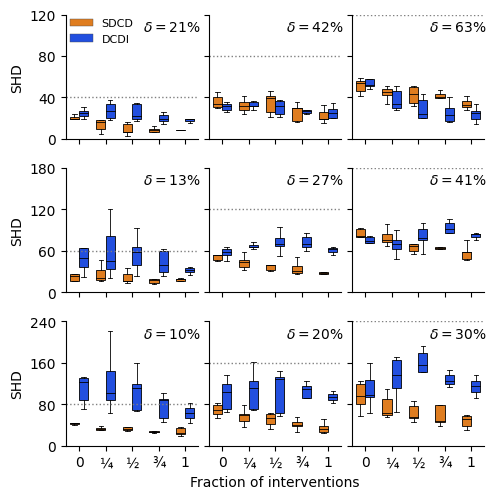

In [11]:
# plot
n_d = 3
n_s = 3
fig, axs = plt.subplots(n_d, n_s, figsize=(1.7 * n_s, 1.7 * n_d), sharex=True, sharey="row", dpi=100)


PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    "linewidth":0.6,
    "width": 0.7,
    "showfliers":False,
}

fdata = data[data["Name"].isin(["SDCI", "DCDI"])]
ds = [20, 30, 40]
ss = [2, 4, 6]

for i, d in enumerate(ds):
    n_edges = []
    for j, s in enumerate(ss):
        ax = axs[i, j]
        sns.boxplot(
            data=fdata[(fdata["d"] == d) & (fdata["s"] == s)],
            x="intervention_frac",
            y="shd",
            hue="Name",
            ax=ax,
            hue_order=["SDCI", "DCDI"],
            palette=PALETTE,
            **PROPS,
        )
        n_edge = d*s
        n_edges.append(n_edge)
        ax.axhline(n_edge, 0,1, c="gray", lw=1, ls=":")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #         ax.set_xlim(0,1)
        
        info = f"$\\delta={int(s*2 / (d-1)*100)}\\%$"
        ax.text(0.8, 0.9, info,
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes
        )

#         ax.set_title(info)
        if i == n_d - 1:
            ax.set_xlabel("Intervention Fraction")
        if j == 0:
            ax.set_ylabel("SHD")
        else:
            ax.set_ylabel("")
        if i == 2:
            if j == 1:
                ax.set_xlabel("Fraction of interventions")
            else:
                ax.set_xlabel("")
                
            ax.set_xticklabels(["0", "¼", "½", "¾", "1"])
        else:
            ax.set_xlabel("")
#         ax.legend()

        if i == 0 and j == 0:
            legend = ax.legend(loc="upper left", fontsize=8,bbox_to_anchor=(-0.04,1.05) )
            legend.set_title(None)
            legend.set_frame_on(False)
            legend.get_texts()[0].set_text('SDCD')
        else:
            ax.get_legend().set_visible(False)
    
    ax.set_ylim(0, max(n_edges))
    ax.set_yticks([0] + n_edges)
    

fig.tight_layout(w_pad=0, )
plt.savefig("intervention.frac.svg", bbox_inches="tight", pad_inches=0, )


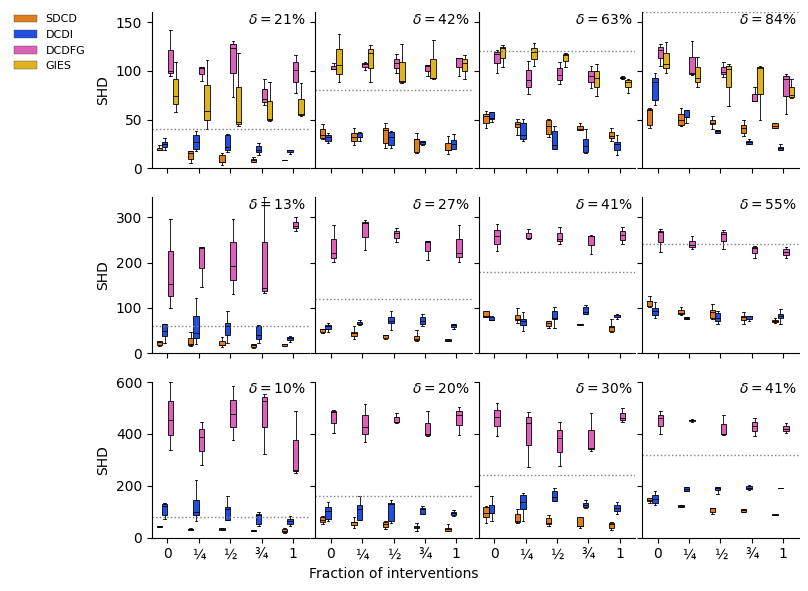

In [25]:
# plot intervention w dcdfg and gies
n_d = 3
n_s = 4
fig, axs = plt.subplots(n_d, n_s, figsize=(2 * n_s, 2 * n_d), sharex=True, sharey="row", dpi=100)


PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    "linewidth":0.6,
    "width": 0.7,
    "showfliers":False,
}

# data = data[data["Name"].isin(["SDCI", "DCDI"])]
ds = [20, 30, 40]
ss = [2, 4, 6, 8]

for i, d in enumerate(ds):
    n_edges = []
    max_d_shd = data[(data["d"] == d)]["shd"].max()
    for j, s in enumerate(ss):
        ax = axs[i, j]
        ds_data = data[(data["d"] == d) & (data["s"] == s)]
        sns.boxplot(
            data=ds_data,
            x="intervention_frac",
            y="shd",
            hue="Name",
            ax=ax,
            hue_order=["SDCI", "DCDI", "DCDFG", "GIES"],
            palette=PALETTE,
            **PROPS,
        )
        n_edge = d*s
        n_edges.append(n_edge)
        ax.axhline(n_edge, 0,1, c="gray", lw=1, ls=":")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #         ax.set_xlim(0,1)
        
        info = f"$\\delta={int(s*2 / (d-1)*100)}\\%$"
        ax.text(0.8, 0.95, info,
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes
        )

#         ax.set_title(info)
        if i == n_d - 1:
            ax.set_xlabel("Intervention Fraction")
        if j == 0:
            ax.set_ylabel("SHD")
        else:
            ax.set_ylabel("")
        if i == 2:
            if j == 1:
                ax.set_xlabel("Fraction of interventions")
            else:
                ax.set_xlabel("")
                
            ax.set_xticklabels(["0", "¼", "½", "¾", "1"])
        else:
            ax.set_xlabel("")
#         ax.legend()

        if i == 0 and j == 0:
            legend = ax.legend(loc="upper left", fontsize=8,bbox_to_anchor=(-.94,1.05) )
            legend.set_title(None)
            legend.set_frame_on(False)
            legend.get_texts()[0].set_text('SDCD')
        else:
            ax.get_legend().set_visible(False)
    
    ax.set_ylim(0, max(max(n_edges), max_d_shd))
    # ax.set_yticks([0] + n_edges)
    

fig.tight_layout(w_pad=0, )
plt.savefig("intervention_full.frac.svg", bbox_inches="tight", pad_inches=0, )

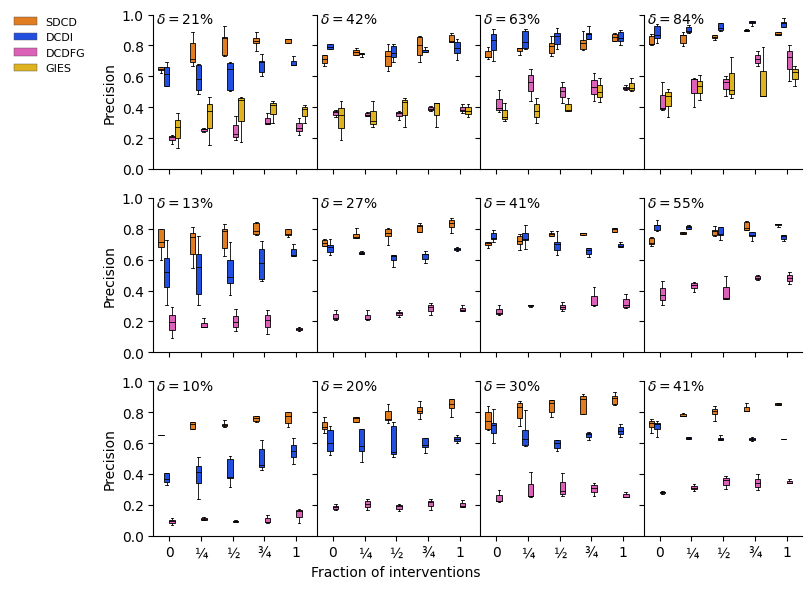

In [41]:
# plot intervention w.r.t. precisio
n_d = 3
n_s = 4
fig, axs = plt.subplots(n_d, n_s, figsize=(2 * n_s, 2 * n_d), sharex=True, sharey="row", dpi=100)


PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    "linewidth":0.6,
    "width": 0.7,
    "showfliers":False,
}

# data = data[data["Name"].isin(["SDCI", "DCDI"])]
ds = [20, 30, 40]
ss = [2, 4, 6, 8]

for i, d in enumerate(ds):
    n_edges = []
    max_d_shd = data[(data["d"] == d)]["shd"].max()
    for j, s in enumerate(ss):
        ax = axs[i, j]
        ds_data = data[(data["d"] == d) & (data["s"] == s)]
        sns.boxplot(
            data=ds_data,
            x="intervention_frac",
            y="precision",
            hue="Name",
            ax=ax,
            hue_order=["SDCI", "DCDI", "DCDFG", "GIES"],
            palette=PALETTE,
            **PROPS,
        )
        n_edge = d*s
        n_edges.append(n_edge)
        ax.axhline(n_edge, 0,1, c="gray", lw=1, ls=":")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #         ax.set_xlim(0,1)
        
        info = f"$\\delta={int(s*2 / (d-1)*100)}\\%$"
        ax.text(0.2, 0.97, info,
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes
        )

#         ax.set_title(info)
        if i == n_d - 1:
            ax.set_xlabel("Intervention Fraction")
        if j == 0:
            ax.set_ylabel("Precision")
        else:
            ax.set_ylabel("")
        if i == 2:
            if j == 1:
                ax.set_xlabel("Fraction of interventions")
            else:
                ax.set_xlabel("")
                
            ax.set_xticklabels(["0", "¼", "½", "¾", "1"])
        else:
            ax.set_xlabel("")
#         ax.legend()

        if i == 0 and j == 0:
            legend = ax.legend(loc="upper left", fontsize=8,bbox_to_anchor=(-.94,1.05) )
            legend.set_title(None)
            legend.set_frame_on(False)
            legend.get_texts()[0].set_text('SDCD')
        else:
            ax.get_legend().set_visible(False)
    
    ax.set_ylim(0, 1)
    # ax.set_yticks([0] + n_edges)
    

fig.tight_layout(w_pad=0, )
plt.savefig("intervention_full_precision.frac.svg", bbox_inches="tight", pad_inches=0, )

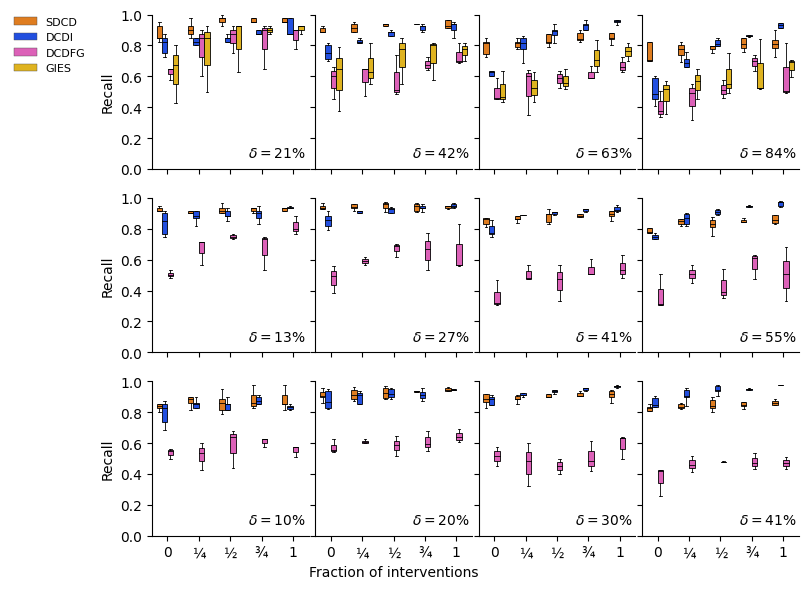

In [39]:
# plot intervention w.r.t. precisio
n_d = 3
n_s = 4
fig, axs = plt.subplots(n_d, n_s, figsize=(2 * n_s, 2 * n_d), sharex=True, sharey="row", dpi=100)


PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    "linewidth":0.6,
    "width": 0.7,
    "showfliers":False,
}

# data = data[data["Name"].isin(["SDCI", "DCDI"])]
ds = [20, 30, 40]
ss = [2, 4, 6, 8]

for i, d in enumerate(ds):
    n_edges = []
    max_d_shd = data[(data["d"] == d)]["shd"].max()
    for j, s in enumerate(ss):
        ax = axs[i, j]
        ds_data = data[(data["d"] == d) & (data["s"] == s)]
        sns.boxplot(
            data=ds_data,
            x="intervention_frac",
            y="recall",
            hue="Name",
            ax=ax,
            hue_order=["SDCI", "DCDI", "DCDFG", "GIES"],
            palette=PALETTE,
            **PROPS,
        )
        n_edge = d*s
        n_edges.append(n_edge)
        ax.axhline(n_edge, 0,1, c="gray", lw=1, ls=":")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #         ax.set_xlim(0,1)
        
        info = f"$\\delta={int(s*2 / (d-1)*100)}\\%$"
        ax.text(0.8, 0.1, info,
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes
        )

#         ax.set_title(info)
        if i == n_d - 1:
            ax.set_xlabel("Intervention Fraction")
        if j == 0:
            ax.set_ylabel("Recall")
        else:
            ax.set_ylabel("")
        if i == 2:
            if j == 1:
                ax.set_xlabel("Fraction of interventions")
            else:
                ax.set_xlabel("")
                
            ax.set_xticklabels(["0", "¼", "½", "¾", "1"])
        else:
            ax.set_xlabel("")
#         ax.legend()

        if i == 0 and j == 0:
            legend = ax.legend(loc="upper left", fontsize=8,bbox_to_anchor=(-.94,1.05) )
            legend.set_title(None)
            legend.set_frame_on(False)
            legend.get_texts()[0].set_text('SDCD')
        else:
            ax.get_legend().set_visible(False)
    
    ax.set_ylim(0, 1)
    # ax.set_yticks([0] + n_edges)
    

fig.tight_layout(w_pad=0, )
plt.savefig("intervention_full_recall.frac.svg", bbox_inches="tight", pad_inches=0, )

In [89]:
# shd data as a table
def format_mean_std(row):
    if np.isnan(row[('shd', 'mean')]):
        return "NA"
    return f"{row[('shd', 'mean')]:.1f} ${{\scriptstyle \pm {row[('shd', 'std')]:.1f}}}$"

data['method'] = pd.Categorical(data['Name'], categories=["SDCI", "DCDI", "DCDFG", "GIES"], ordered=True)
grouped = data.groupby(['method', 's', 'd', 'intervention_frac']).agg({'shd': ['mean', 'std']}).reset_index()
grouped['combined'] = grouped.apply(format_mean_std, axis=1)
pivot_table = pd.pivot_table(grouped, values='combined', index=['s', 'd', 'intervention_frac'], columns=['method'], aggfunc=lambda x: str(next(iter(x))))

# Export to LaTeX
pivot_table = pivot_table.iloc[:, :4]
pivot_table.columns = ["SDCD", "DCDI", "DCDFG", "GIES"]
latex_str = pivot_table.to_latex(escape=False, na_rep='')
print(latex_str)

\begin{tabular}{lllllll}
\toprule
  &    &      &                             SDCD &                             DCDI &                             DCDFG &                             GIES \\
s & d & intervention_frac &                                  &                                  &                                   &                                  \\
\midrule
2 & 20 & 0.00 &    18.0 ${\scriptstyle \pm 6.5}$ &    24.8 ${\scriptstyle \pm 4.6}$ &   112.3 ${\scriptstyle \pm 25.8}$ &   80.3 ${\scriptstyle \pm 26.1}$ \\
  &    & 0.25 &    13.4 ${\scriptstyle \pm 5.7}$ &    27.4 ${\scriptstyle \pm 8.6}$ &     99.0 ${\scriptstyle \pm 7.8}$ &   70.0 ${\scriptstyle \pm 36.8}$ \\
  &    & 0.50 &     9.4 ${\scriptstyle \pm 5.4}$ &    25.4 ${\scriptstyle \pm 8.5}$ &   109.0 ${\scriptstyle \pm 31.4}$ &   69.7 ${\scriptstyle \pm 41.9}$ \\
  &    & 0.75 &     9.0 ${\scriptstyle \pm 2.1}$ &    19.8 ${\scriptstyle \pm 4.8}$ &    76.0 ${\scriptstyle \pm 14.2}$ &   62.7 ${\scriptstyle \pm 22.0}$ 

/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/3334600934.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_table = pd.pivot_table(grouped, values='combined', index=['s', 'd', 'intervention_frac'], columns=['method'], aggfunc=lambda x: str(next(iter(x))))
/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/3334600934.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = pivot_table.to_latex(escape=False, na_rep='')


# DCDI data

In [90]:
sdcd = pd.read_csv("final_experiments/dcdi-data.csv")
sdcd["nodes_edges"] = sdcd["Name"].str.split("_").str[1:3].str.join("_")

In [94]:
dcdi_linear = pd.read_csv("dcdi_data/linear.csv", index_col=0)
dcdi_additive = pd.read_csv("dcdi_data/additive.csv", index_col=0)
dcdi_nn = pd.read_csv("dcdi_data/nn.csv", index_col=0)

In [95]:
# shd is not the last epoch: 0.1_dag_shd is

sdcd_results = sdcd.groupby(["dataset_name", "nodes_edges"])["0.1_dag_shd"].agg(["mean", "std"]).reset_index()
for name, df in [("linear", dcdi_linear), ('nnadd', dcdi_additive), ('nn', dcdi_nn)]:
    keep = ["DCDI-DSF", "DCDI-G"]
    df.drop(list(set(df.index) - set(keep)), inplace=True)
    tmp = sdcd_results[sdcd_results["dataset_name"].str.contains(name + "_")]
    tmp = tmp.sort_values("nodes_edges")[["mean", "std"]].values.reshape(-1).tolist()
    df.loc["SDCD"] = tmp
    df["average__shd_mean"] = df[[c for c in df.columns if "mean" in c]].mean(axis=1)
    df["average__shd_std"] = df[[c for c in df.columns if "std" in c]].pow(2).mean(axis=1).pow(0.5)
    

ValueError: cannot set a row with mismatched columns

In [44]:
for df in [dcdi_linear, dcdi_additive, dcdi_nn]:
    
    for c in list(df.columns[::2]):
        dataset = "_".join(c.split("_")[:2])
        best_row = df.index[np.argmin(df[c].values)]
        df[dataset] = (
            "$"
            + df[dataset + "_shd_mean"].round(1).astype(str)
            + r"{\scriptstyle \pm"
            + df[dataset + "_shd_std"].round(1).astype(str)
            + r"}$"
        )
        df.loc[best_row, dataset] = r"$\mathbf{" + df.loc[best_row, dataset][1:-1] + r"}$"
        del df[dataset + "_shd_mean"]
        del df[dataset + "_shd_std"]
    df.columns = ["d=10, s=1", "d=10, s=4", "d=20, s=1", "d=20, s=4", "average"]

In [45]:
print(dcdi_linear.iloc[:, :4].to_latex())

\begin{tabular}{lllll}
\toprule
 & d=10, s=1 & d=10, s=4 & d=20, s=1 & d=20, s=4 \\
Method &  &  &  &  \\
\midrule
DCDI-G & $1.3{\scriptstyle \pm1.9}$ & $\mathbf{3.3{\scriptstyle \pm2.1}}$ & $5.4{\scriptstyle \pm4.5}$ & $23.7{\scriptstyle \pm5.6}$ \\
DCDI-DSF & $0.9{\scriptstyle \pm1.3}$ & $3.7{\scriptstyle \pm2.3}$ & $3.6{\scriptstyle \pm2.7}$ & $\mathbf{16.6{\scriptstyle \pm6.4}}$ \\
SDCD & $\mathbf{0.7{\scriptstyle \pm1.2}}$ & $5.2{\scriptstyle \pm3.5}$ & $\mathbf{1.4{\scriptstyle \pm3.4}}$ & $18.8{\scriptstyle \pm10.5}$ \\
\bottomrule
\end{tabular}



In [46]:
display(dcdi_linear)
display(dcdi_additive)
display(dcdi_nn)


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$1.3{\scriptstyle \pm1.9}$,$\mathbf{3.3{\scriptstyle \pm2.1}}$,$5.4{\scriptstyle \pm4.5}$,$23.7{\scriptstyle \pm5.6}$,$8.4{\scriptstyle \pm3.9}$
DCDI-DSF,$0.9{\scriptstyle \pm1.3}$,$3.7{\scriptstyle \pm2.3}$,$3.6{\scriptstyle \pm2.7}$,$\mathbf{16.6{\scriptstyle \pm6.4}}$,$\mathbf{6.2{\scriptstyle \pm3.7}}$
SDCD,$\mathbf{0.7{\scriptstyle \pm1.2}}$,$5.2{\scriptstyle \pm3.5}$,$\mathbf{1.4{\scriptstyle \pm3.4}}$,$18.8{\scriptstyle \pm10.5}$,$6.5{\scriptstyle \pm5.8}$


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$5.2{\scriptstyle \pm7.5}$,$\mathbf{4.3{\scriptstyle \pm2.4}}$,$21.8{\scriptstyle \pm30.1}$,$35.2{\scriptstyle \pm13.2}$,$16.6{\scriptstyle \pm16.9}$
DCDI-DSF,$4.2{\scriptstyle \pm5.6}$,$5.5{\scriptstyle \pm2.4}$,$4.3{\scriptstyle \pm1.9}$,$26.7{\scriptstyle \pm16.9}$,$10.2{\scriptstyle \pm9.0}$
SDCD,$\mathbf{0.6{\scriptstyle \pm0.7}}$,$4.8{\scriptstyle \pm2.1}$,$\mathbf{4.1{\scriptstyle \pm3.0}}$,$\mathbf{18.0{\scriptstyle \pm7.3}}$,$\mathbf{6.9{\scriptstyle \pm4.1}}$


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$2.3{\scriptstyle \pm3.6}$,$2.4{\scriptstyle \pm1.6}$,$13.9{\scriptstyle \pm20.3}$,$16.8{\scriptstyle \pm8.7}$,$8.9{\scriptstyle \pm11.2}$
DCDI-DSF,$7.0{\scriptstyle \pm10.7}$,$\mathbf{1.6{\scriptstyle \pm1.6}}$,$8.3{\scriptstyle \pm4.1}$,$\mathbf{11.8{\scriptstyle \pm2.1}}$,$7.2{\scriptstyle \pm5.9}$
SDCD,$\mathbf{0.7{\scriptstyle \pm0.7}}$,$7.3{\scriptstyle \pm3.0}$,$\mathbf{3.0{\scriptstyle \pm2.5}}$,$14.9{\scriptstyle \pm1.9}$,$\mathbf{6.5{\scriptstyle \pm2.2}}$


In [47]:
report_latex = pd.concat({
    "L": dcdi_linear.T.iloc[:-1],
    "NL-Add": dcdi_additive.T.iloc[:-1],
    "NL-NN": dcdi_nn.T.iloc[:-1],
})

report_latex = report_latex.iloc[:, [2,0,1]]

report_latex = report_latex.reset_index()
report_latex["d"] = report_latex["level_1"].str.split(",").str[0]
report_latex["s"] = report_latex["level_1"].str.split(",").str[1]
report_latex["s"].replace(" s=1", 1, inplace=True)
report_latex["s"].replace(" s=4", 4, inplace=True)
report_latex["d"].replace("d=10", 10, inplace=True)
report_latex["d"].replace("d=20", 20, inplace=True)
report_latex = report_latex.sort_values(["s", "d"])
report_latex = report_latex.set_index(["s", "d", "level_0"])
del report_latex["level_1"]
print(report_latex.to_latex())
report_latex

\begin{tabular}{llllll}
\toprule
 &  & Method & SDCD & DCDI-G & DCDI-DSF \\
s & d & level_0 &  &  &  \\
\midrule
\multirow[t]{6}{*}{1} & \multirow[t]{3}{*}{10} & L & $\mathbf{0.7{\scriptstyle \pm1.2}}$ & $1.3{\scriptstyle \pm1.9}$ & $0.9{\scriptstyle \pm1.3}$ \\
 &  & NL-Add & $\mathbf{0.6{\scriptstyle \pm0.7}}$ & $5.2{\scriptstyle \pm7.5}$ & $4.2{\scriptstyle \pm5.6}$ \\
 &  & NL-NN & $\mathbf{0.7{\scriptstyle \pm0.7}}$ & $2.3{\scriptstyle \pm3.6}$ & $7.0{\scriptstyle \pm10.7}$ \\
\cline{2-6}
 & \multirow[t]{3}{*}{20} & L & $\mathbf{1.4{\scriptstyle \pm3.4}}$ & $5.4{\scriptstyle \pm4.5}$ & $3.6{\scriptstyle \pm2.7}$ \\
 &  & NL-Add & $\mathbf{4.1{\scriptstyle \pm3.0}}$ & $21.8{\scriptstyle \pm30.1}$ & $4.3{\scriptstyle \pm1.9}$ \\
 &  & NL-NN & $\mathbf{3.0{\scriptstyle \pm2.5}}$ & $13.9{\scriptstyle \pm20.3}$ & $8.3{\scriptstyle \pm4.1}$ \\
\cline{1-6} \cline{2-6}
\multirow[t]{6}{*}{4} & \multirow[t]{3}{*}{10} & L & $5.2{\scriptstyle \pm3.5}$ & $\mathbf{3.3{\scriptstyle \pm2.1}}$ & $

Method                                        SDCD   
s d  level_0                                         
1 10 L         $\mathbf{0.7{\scriptstyle \pm1.2}}$  \
     NL-Add    $\mathbf{0.6{\scriptstyle \pm0.7}}$   
     NL-NN     $\mathbf{0.7{\scriptstyle \pm0.7}}$   
  20 L         $\mathbf{1.4{\scriptstyle \pm3.4}}$   
     NL-Add    $\mathbf{4.1{\scriptstyle \pm3.0}}$   
     NL-NN     $\mathbf{3.0{\scriptstyle \pm2.5}}$   
4 10 L                  $5.2{\scriptstyle \pm3.5}$   
     NL-Add             $4.8{\scriptstyle \pm2.1}$   
     NL-NN              $7.3{\scriptstyle \pm3.0}$   
  20 L                $18.8{\scriptstyle \pm10.5}$   
     NL-Add   $\mathbf{18.0{\scriptstyle \pm7.3}}$   
     NL-NN             $14.9{\scriptstyle \pm1.9}$   

Method                                     DCDI-G   
s d  level_0                                        
1 10 L                 $1.3{\scriptstyle \pm1.9}$  \
     NL-Add            $5.2{\scriptstyle \pm7.5}$   
     NL-NN             $2.3{\scriptstyle \pm3.6}$   
  20 L                 $5.4{\scriptstyle \pm4.5}$   
     NL-Add          $21.8{\scriptstyle \pm30.1}$   
     NL-NN           $13.9{\scriptstyle \pm20.3}$   
4 10 L        $\mathbf{3.3{\scriptstyle \pm2.1}}$   
     NL-Add   $\mathbf{4.3{\scriptstyle \pm2.4}}$   
     NL-NN             $2.4{\scriptstyle \pm1.6}$   
  20 L                $23.7{\scriptstyle \pm5.6}$   
     NL-Add          $35.2{\scriptstyle \pm13.2}$   
     NL-NN            $16.8{\scriptstyle \pm8.7}$   

Method                                    DCDI-DSF  
s d  level_0                                        
1 10 L                  $0.9{\scriptstyle \pm1.3}$  
     NL-Add             $4.2{\scriptstyle \pm5.6}$  
     NL-NN             $7.0{\scriptstyle \pm10.7}$  
  20 L                  $3.6{\scriptstyle \pm2.7}$  
     NL-Add             $4.3{\scriptstyle \pm1.9}$  
     NL-NN              $8.3{\scriptstyle \pm4.1}$  
4 10 L                  $3.7{\scriptstyle \pm2.3}$  
     NL-Add             $5.5{\scriptstyle \pm2.4}$  
     NL-NN     $\mathbf{1.6{\scriptstyle \pm1.6}}$  
  20 L        $\mathbf{16.6{\scriptstyle \pm6.4}}$  
     NL-Add           $26.7{\scriptstyle \pm16.9}$  
     NL-NN    $\mathbf{11.8{\scriptstyle \pm2.1}}$

# Observational benchmark

In [175]:
observational = pd.read_csv("./final_experiments/observational.csv")

# observational = observational[observational["Hostname"] == "yolanda"]
# observational = observational[observational["d"] != 70]  # we do d=10-50, d=100-500

observational.loc[observational["model"] == "SDCI-no-s1-2", "Name"] = "SDCI-no-s1-2"

In [97]:
observational.groupby(["Name", "d"]).count()[["shd"]].reset_index().pivot_table(index="Name", columns="d", values="shd")

d,10,20,30,40,50,100,200,300,400,500,700,1000,2000,3000,4000
Name,,,,,,,,,,,,,,,
DAGMA,3.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DCDFG,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
DCDI,5.0,5.0,5.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GIES,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOBEARS,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
NOTEARS,5.0,5.0,5.0,5.0,3.0,3.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
SDCI,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
SDCI-GPU,NaN,NaN,NaN,NaN,3.0,3.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,2.0,2.0
SDCI-no-s1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN


### Quick ablation study

In [102]:
methods = [
        "SDCI",
        "SDCI-warm", 
        "SDCI-warm-nomask" , 
        "SDCI-no-s1", 
        "SDCI-no-s1-2", 
        "DCDI"
    ]
tmp = observational[
    (observational["d"] <= 50) 
    & (observational["seed"] <= 2) 
    & observational["Name"].isin(methods)
].groupby(["d", "Name"])[["shd"]]
# tmp.count()
print(tmp.mean().reset_index().pivot_table(index="Name", columns="d", values="shd").loc[methods].round(1).to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
d &    10 &    20 &     30 &     40 &     50 \\
Name             &       &       &        &        &        \\
\midrule
SDCI             &  14.7 &  40.3 &   54.3 &   69.0 &   67.3 \\
SDCI-warm        &  14.7 &  40.7 &   55.0 &   68.7 &   69.7 \\
SDCI-warm-nomask &  19.3 &  69.7 &  156.0 &  272.7 &  428.3 \\
SDCI-no-s1       &  19.3 &  68.3 &  155.3 &  272.3 &  422.3 \\
SDCI-no-s1-2     &  16.3 &  56.7 &   95.0 &  135.0 &    NaN \\
DCDI             &  24.0 &  35.7 &   56.7 &   87.0 &    NaN \\
\bottomrule
\end{tabular}



/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/2625220434.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tmp.mean().reset_index().pivot_table(index="Name", columns="d", values="shd").loc[methods].round(1).to_latex(escape=False))


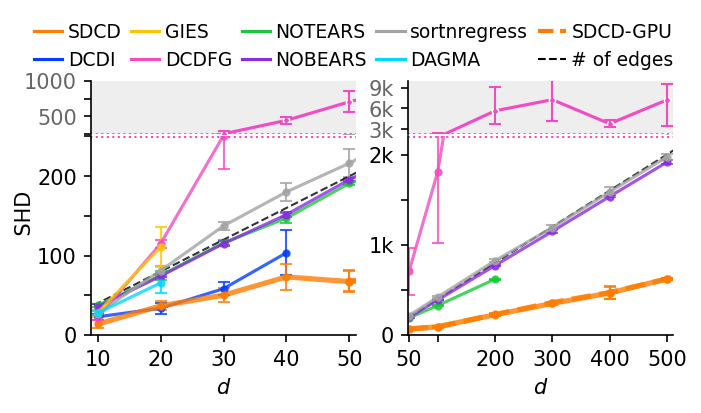

In [103]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(5, 2.2),
    dpi=150,
    gridspec_kw={"height_ratios": [0.8, 3]},
)

metric = "shd"
DEFAULT_LW = 1.5
SDCI_LW = 2.5
ERR_KW = {
    "elinewidth": 1,
    "capsize": 3,
}
HUE_ORDER = [
    "DCDI",
    "SDCI",
    "SDCI-GPU",
    "NOTEARS",
    "NOBEARS",
    "DCDFG",
    "sortnregress",
    "GIES",
    "DAGMA",
]

ALPHA = 0.8

for method_name in HUE_ORDER:
    ls = "-"
    lw = DEFAULT_LW
    if method_name == "SDCI":
        lw = SDCI_LW
    if method_name == "SDCI-GPU":
        lw = SDCI_LW
        ls = "--"

    data_filtered = observational[
        observational["Name"] == method_name
    ]
    data_groupby = data_filtered.groupby("d")[metric].agg(["mean", "std"])
    for ax in [axs[1,0], axs[1,1]]:
        ax.errorbar(
            x=data_groupby.index,
            y=data_groupby["mean"],
            yerr=data_groupby["std"],
            color=PALETTE[method_name],
            linewidth=lw,
            linestyle=ls,
            marker=".",
            **ERR_KW,
            alpha=ALPHA,
        )
    


# Plot DCDFG data separately in the upper part; hue order is for the legend
sns.lineplot(
    data=observational,
    x="d",
    y=metric,
    hue="Name",
    palette=PALETTE,
    err_style="bars",
    err_kws=ERR_KW,
    linewidth=DEFAULT_LW,
    marker=".",
    ax=axs[0, 0],
    hue_order=[
        "SDCI",
        "DCDI",
        "GIES",
        "DCDFG",
        "NOTEARS",
        "NOBEARS",
        "sortnregress",
        "DAGMA",
    ],
)
sns.lineplot(
    data=observational,
    x="d",
    y=metric,
    hue="Name",
    palette=PALETTE,
    err_style="bars",
    err_kws=ERR_KW,
    marker=".",
    linewidth=DEFAULT_LW,
    ax=axs[0, 1],
    legend=None,
    hue_order=PALETTE,
)

for ax in axs[0]:
    ax.set_facecolor("#eeeeee")


# do the cut
axs[1, 0].set_ylim(0, 250)
axs[0, 0].set_ylim(255, 900)
axs[1, 0].set_yticks([0, 50, 100, 150, 200, 250])
axs[1, 0].set_yticklabels([0, "", 100, "", 200, ""])
axs[0, 0].set_yticks([250, 500, 750, 1000])
axs[0, 0].set_yticklabels(["", "500", "", "1000"], c="#666666")

axs[1, 1].set_ylim(0, 2200)
axs[0, 1].set_ylim(2300, 10000)
axs[1, 1].set_yticks([0, 500, 1000, 1500, 2000])
axs[1, 1].set_yticklabels([0, "", "1k", "", "2k"])
axs[0, 1].set_yticks([3000, 6000, 9000])
axs[0, 1].set_yticklabels(["3k", "6k", "9k"], c="#666666")

axs[1, 0].hlines(y=249, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)
axs[0, 0].hlines(y=256, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)

axs[1, 1].hlines(y=2190, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)
axs[0, 1].hlines(y=2310, xmin=0, xmax=1100, color=PALETTE["DCDFG"], ls=":", lw=1)

#########

for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[1, j].set_xlabel("")
    axs[0, j].set_xticks([])
    axs[1, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[1, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])

    axs[1, j].plot([0, 1000], [4 * 0, 4 * 1000], ls="--", c="black", alpha=0.8, lw=1)


axs[1, 0].set_xlim(9, 51)
axs[0, 0].set_xlim(9, 51)

axs[1, 1].set_xlim(49, 510)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].spines["bottom"].set_visible(False)
axs[1, 0].spines["top"].set_visible(False)
axs[1, 0].spines["right"].set_visible(False)

axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)
axs[0, 1].spines["bottom"].set_visible(False)
axs[1, 1].spines["top"].set_visible(False)
axs[1, 1].spines["right"].set_visible(False)
# axs[1,0].spines['bottom'].set_visible(False)

axs[0, 0].set_ylabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
axs[1, 0].set_ylabel("       SHD", labelpad=1)


axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])
axs[0, 0].plot([-1], [-1], lw=1, ls="--", label="# of edges", c="black")

legend = axs[0, 0].legend(
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.28, 2.43),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
)
legend.get_frame().set_visible(False)
legend.get_texts()[0].set_text("SDCD")

plt.subplots_adjust(
    hspace=0.02,
    wspace=0.2,
)

axs[1, 0].set_xlabel("$d$")
axs[1, 1].set_xlabel("$d$")
plt.savefig("observational-shd.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[legend])
plt.show()

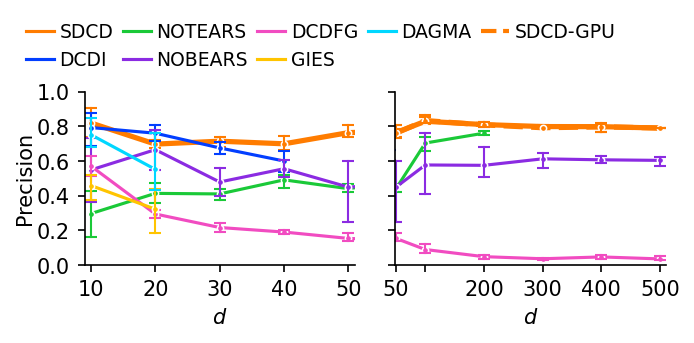

In [169]:
# observational precision plot
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
metric = "precision"
for i in range(3):
    ls = "-"
    lw = DEFAULT_LW
    if i == 1:
        observational_filtered = observational[
            ~observational["Name"].isin(["SDCI", "SDCI-GPU"])
        ]
    elif i == 0:
        observational_filtered = observational[(observational["Name"] == "SDCI")]
        lw = SDCI_LW
    elif i == 2:
        observational_filtered = observational[(observational["Name"] == "SDCI-GPU")]
        lw = SDCI_LW
        ls = "--"

    observational_filtered = observational_filtered.copy()
    observational_filtered["train_time"] /= 60

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None if i != 0 else True,
        hue_order=[
            "SDCI",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
        hue_order=[
            "SDCI",
            "SDCI-GPU",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[0, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])

axs[0, 0].set_xlim(9, 51)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 1].set_yticklabels([])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("Precision", labelpad=0.8)
axs[0, 1].set_ylabel("")

axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])

legend = axs[0, 0].legend(
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.28, 1.5),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
)
legend.get_frame().set_visible(False)
legend.get_texts()[0].set_text("SDCD")

plt.subplots_adjust(
    hspace=0.02,
    wspace=0.15,
)

plt.savefig("observational-precision.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[legend])
plt.show()

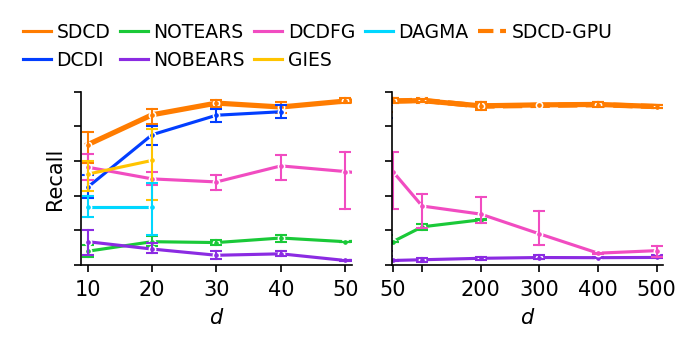

In [165]:
# observational recall plot
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
metric = "recall"
for i in range(3):
    ls = "-"
    lw = DEFAULT_LW
    if i == 1:
        observational_filtered = observational[
            ~observational["Name"].isin(["SDCI", "SDCI-GPU"])
        ]
    elif i == 0:
        observational_filtered = observational[(observational["Name"] == "SDCI")]
        lw = SDCI_LW
    elif i == 2:
        observational_filtered = observational[(observational["Name"] == "SDCI-GPU")]
        lw = SDCI_LW
        ls = "--"

    observational_filtered = observational_filtered.copy()
    observational_filtered["train_time"] /= 60

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None if i != 0 else True,
        hue_order=[
            "SDCI",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
        hue_order=[
            "SDCI",
            "SDCI-GPU",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[0, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])

axs[0, 0].set_xlim(9, 51)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 0].set_yticklabels([])
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 1].set_yticklabels([])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("Recall", labelpad=0.8)
axs[0, 1].set_ylabel("")

axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])

legend = axs[0, 0].legend(
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.28, 1.5),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
)
legend.get_frame().set_visible(False)
legend.get_texts()[0].set_text("SDCD")

plt.subplots_adjust(
    hspace=0.02,
    wspace=0.15,
)

plt.savefig("observational-recall.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[legend])
plt.show()

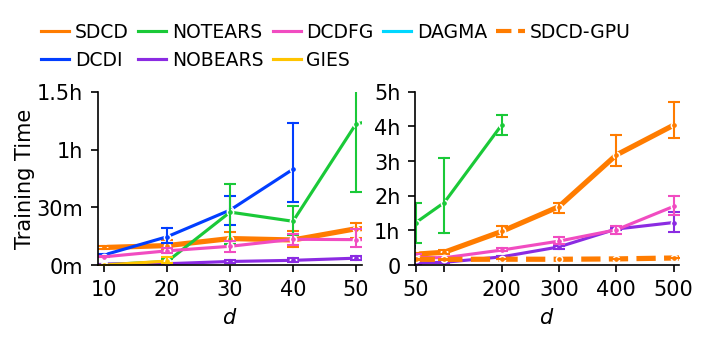

In [131]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
metric = "train_time"
for i in range(3):
    ls = "-"
    lw = DEFAULT_LW
    if i == 1:
        observational_filtered = observational[
            ~observational["Name"].isin(["SDCI", "SDCI-GPU"])
        ]
    elif i == 0:
        observational_filtered = observational[(observational["Name"] == "SDCI")]
        lw = SDCI_LW
    elif i == 2:
        observational_filtered = observational[(observational["Name"] == "SDCI-GPU")]
        lw = SDCI_LW
        ls = "--"

    observational_filtered = observational_filtered.copy()
    observational_filtered["train_time"] /= 60

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None if i != 0 else True,
        hue_order=[
            "SDCI",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
        hue_order=[
            "SDCI",
            "SDCI-GPU",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[0, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])

axs[0, 0].set_xlim(9, 51)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].set_ylim(0, 90)
axs[0, 0].set_yticks([0, 30, 60, 90])
axs[0, 0].set_yticklabels(["0m", "30m", "1h", "1.5h"])
axs[0, 1].set_ylim(0, 300)
axs[0, 1].set_yticks([0, 60, 120, 180, 240, 300])
axs[0, 1].set_yticklabels(["0", "1h", "2h", "3h", "4h", "5h"])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("Training Time", labelpad=0.8)
axs[0, 1].set_ylabel("")

axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])

legend = axs[0, 0].legend(
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.28, 1.5),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
)
legend.get_frame().set_visible(False)
legend.get_texts()[0].set_text("SDCD")

plt.subplots_adjust(
    hspace=0.02,
    wspace=0.2,
)

plt.savefig("observational-time.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[legend])
plt.show()

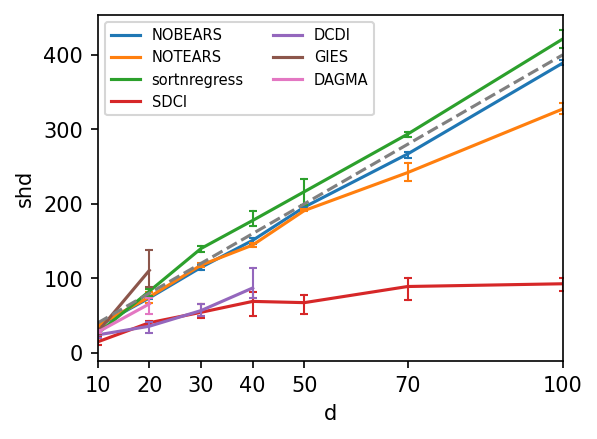

In [171]:
observational_large = observational[(observational["d"] > 700) & (observational["Name"] == "SDCI-GPU")]
observational_large[["d", "shd", "train_time", "precision", "recall"]]

,d,shd,train_time,precision,recall
330,1000,1481.0,1155.893750,0.758024,0.897500
332,1000,1464.0,1040.608328,0.757778,0.907250
334,1000,1371.0,1018.786213,0.766032,0.925750
335,2000,3392.0,2757.324106,0.722521,0.905500
336,2000,3276.0,2700.405865,0.728005,0.915375
337,2000,3402.0,2725.749645,0.720568,0.907375
338,3000,5236.0,5510.863886,0.711521,0.919167
339,3000,5109.0,5456.258696,0.717055,0.921833
340,4000,7324.0,9858.628942,0.700601,0.917875
341,4000,7810.0,8513.347492,0.685812,0.914188


/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/1164973235.py:84: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]


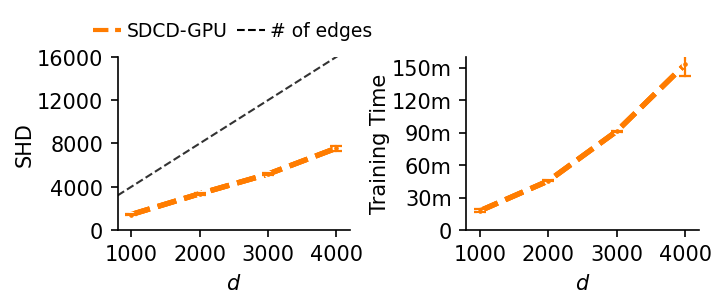

(None,)

In [152]:
# plot shd and runtime side by side
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
for i in range(3):
    ls = "--"
    lw = SDCI_LW
    observational_filtered = observational_large

    observational_filtered = observational_filtered.copy()
    observational_filtered["train_time"] /= 60

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y="shd",
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None if i != 0 else True,
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y="train_time",
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([1000, 2000, 3000, 4000])
    axs[0, j].set_xticklabels([1000, 2000, 3000, 4000])

axs[0, 0].plot([800, 4200], [4 * 800, 4 * 4200], ls="--", c="black", alpha=0.8, lw=1)

axs[0, 0].set_xlim(800, 4200)
axs[0, 1].set_xlim(800, 4200)

axs[0, 0].set_ylim(0, 16000)
axs[0, 0].set_yticks([0, 4000, 8000, 12000, 16000])
# axs[0, 0].set_yticklabels(["0m", "30m", "1h", "1.5h"])
axs[0, 1].set_ylim(0, 160)
axs[0, 1].set_yticks([0, 30, 60, 90, 120, 150])
axs[0, 1].set_yticklabels(["0", "30m", "60m", "90m", "120m", "150m"])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("SHD", labelpad=0.8)
axs[0, 1].set_ylabel("Training Time", labelpad=0.8)

axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])
axs[0, 0].plot([-1], [-1], lw=1, ls="--", label="# of edges", c="black")

legend = axs[0, 0].legend()
legend.get_frame().set_visible(False)
legend.set_visible(False)
handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]
new_legend = axs[0,0].legend(handles[1:], labels[1:],
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.18, 1.3),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
                        )
new_legend.get_frame().set_visible(False)
   
plt.subplots_adjust(
    hspace=0.02,
    wspace=0.5,
)

plt.savefig("observational-large.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[new_legend])
plt.show(),

/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/1563838437.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]


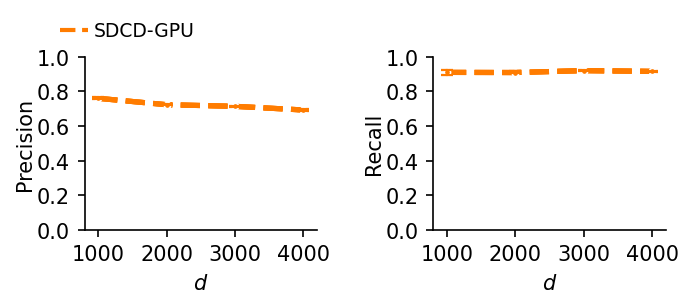

(None,)

In [170]:
# plot recall and precision side by side
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
for i in range(3):
    ls = "--"
    lw = SDCI_LW
    observational_filtered = observational_large

    observational_filtered = observational_filtered.copy()

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y="precision",
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None if i != 0 else True,
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y="recall",
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([1000, 2000, 3000, 4000])
    axs[0, j].set_xticklabels([1000, 2000, 3000, 4000])

axs[0, 0].set_xlim(800, 4200)
axs[0, 1].set_xlim(800, 4200)

axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("Precision", labelpad=0.8)
axs[0, 1].set_ylabel("Recall", labelpad=0.8)

axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])

legend = axs[0, 0].legend()
legend.get_frame().set_visible(False)
legend.set_visible(False)
handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]
new_legend = axs[0,0].legend(handles[1:], labels[1:],
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.18, 1.3),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
                        )
new_legend.get_frame().set_visible(False)
   
plt.subplots_adjust(
    hspace=0.02,
    wspace=0.5,
)

plt.savefig("observational-large-precision-recall.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[new_legend])
plt.show(),

In [195]:
# observational table
def format_mean_std(row):
    if np.isnan(row[('shd', 'mean')]):
        return "NA"
    return f"{row[('shd', 'mean')]:.1f} ${{\scriptstyle \pm {row[('shd', 'std')]:.1f}}}$"

all_observational = observational[["Name", "shd", "d"]]
all_observational = all_observational[all_observational["d"] <= 500]

all_observational['method'] = pd.Categorical(all_observational['Name'], categories=["SDCI", "SDCI-GPU", "DCDI", "DCDFG", "GIES", "DAGMA", "NOTEARS", "NOBEARS", "sortnregress"], ordered=True)
grouped = all_observational.groupby(['method', 'd']).agg({'shd': ['mean', 'std']}).reset_index()
grouped['combined'] = grouped.apply(format_mean_std, axis=1)
pivot_table = pd.pivot_table(grouped, values='combined', index=['d'], columns=['method'], aggfunc=lambda x: str(next(iter(x))))
pivot_table = pivot_table.iloc[:, :len(all_observational["method"].cat.categories)]
pivot_table.columns = pivot_table.columns.get_level_values(1)

# Export to LaTeX
pivot_table.columns = ["SDCD", "SDCD-GPU", "DCDI", "DCDFG", "GIES","DAGMA", "NOTEARS", "NOBEARS", "sortnregress"]
latex_str = pivot_table.to_latex(escape=False, na_rep='')
print(latex_str)

\begin{tabular}{llllllllll}
\toprule
{} &                             SDCD &                         SDCD-GPU &                             DCDI &                               DCDFG &                             GIES &                           DAGMA &                         NOTEARS &                           NOBEARS &                      sortnregress \\
d   &                                  &                                  &                                  &                                     &                                  &                                 &                                 &                                   &                                   \\
\midrule
10  &    13.8 ${\scriptstyle \pm 4.8}$ &                               NA &    23.0 ${\scriptstyle \pm 3.7}$ &       22.0 ${\scriptstyle \pm 3.3}$ &    28.0 ${\scriptstyle \pm 3.6}$ &   27.7 ${\scriptstyle \pm 2.1}$ &   37.4 ${\scriptstyle \pm 2.3}$ &     35.8 ${\scriptstyle \pm 3.8}$ &     27.6 ${\scrip

/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/463018487.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = pivot_table.to_latex(escape=False, na_rep='')


In [196]:
# observational large table
def format_mean_std(row):
    if np.isnan(row[('shd', 'mean')]):
        return "NA"
    return f"{row[('shd', 'mean')]:.1f} ${{\scriptstyle \pm {row[('shd', 'std')]:.1f}}}$"

all_observational = observational[["Name", "shd", "d"]]
all_observational = all_observational[all_observational["d"] > 700]

all_observational['method'] = pd.Categorical(all_observational['Name'], categories=["SDCI-GPU"], ordered=True)
grouped = all_observational.groupby(['method', 'd']).agg({'shd': ['mean', 'std']}).reset_index()
grouped['combined'] = grouped.apply(format_mean_std, axis=1)
pivot_table = pd.pivot_table(grouped, values='combined', index=['d'], columns=['method'], aggfunc=lambda x: str(next(iter(x))))
pivot_table = pivot_table.iloc[:, :len(all_observational["method"].cat.categories)]
pivot_table.columns = pivot_table.columns.get_level_values(1)

# Export to LaTeX
pivot_table.columns = ["SDCD-GPU"]
latex_str = pivot_table.to_latex(escape=False, na_rep='')
print(latex_str)

\begin{tabular}{ll}
\toprule
{} &                           SDCD-GPU \\
d    &                                    \\
\midrule
1000 &   1438.7 ${\scriptstyle \pm 59.2}$ \\
2000 &   3356.7 ${\scriptstyle \pm 70.0}$ \\
3000 &   5172.5 ${\scriptstyle \pm 89.8}$ \\
4000 &  7567.0 ${\scriptstyle \pm 343.7}$ \\
\bottomrule
\end{tabular}



/var/folders/b8/q31klnzn0yx0pkz17v8dpdpm0000gn/T/ipykernel_67195/195102775.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = pivot_table.to_latex(escape=False, na_rep='')
